Data Loaded.
Time Series Data Shape: (34901, 52)
Future Data Shape: (181, 53)
Features Selected.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score: 0.2871
Best Parameters:
  model__colsample_bytree: 0.8599094730571053
  model__gamma: 0.048058924197033726
  model__learning_rate: 0.19033768900236334
  model__max_depth: 6
  model__n_estimators: 339
  model__reg_alpha: 0.26089362334171395
  model__reg_lambda: 0.022956810435577124
  model__subsample: 0.9733745232317932
Model Trained.
Fold 1 Metrics:
  Mean Absolute Error (MAE): 0.33713985322861884
  Root Mean Squared Error (RMSE): 0.3990278616048368
  R² Score: 0.8204922284119612

Fold 2 Metrics:
  Mean Absolute Error (MAE): 0.28956181705122813
  Root Mean Squared Error (RMSE): 0.37133714990066763
  R² Score: 0.7952516770204654

Fold 3 Metrics:
  Mean Absolute Error (MAE): 0.3072445906394752
  Root Mean Squared Error (RMSE): 0.3844018671423505
  R² Score: 0.838713943071024

Fold 4 Metrics:
  Mean Absolute Error (

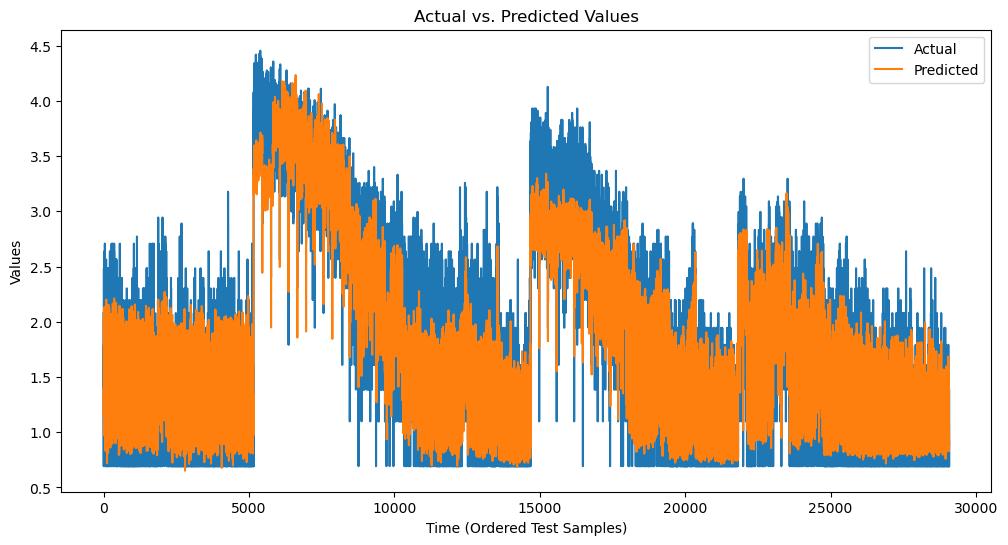

Average MAE across 5 folds: 0.28714946925159845
Average RMSE across 5 folds: 0.35445225479374287
Average R² Score across 5 folds: 0.7916190901494586
Cross-Validation Completed.
Future Predictions Made.


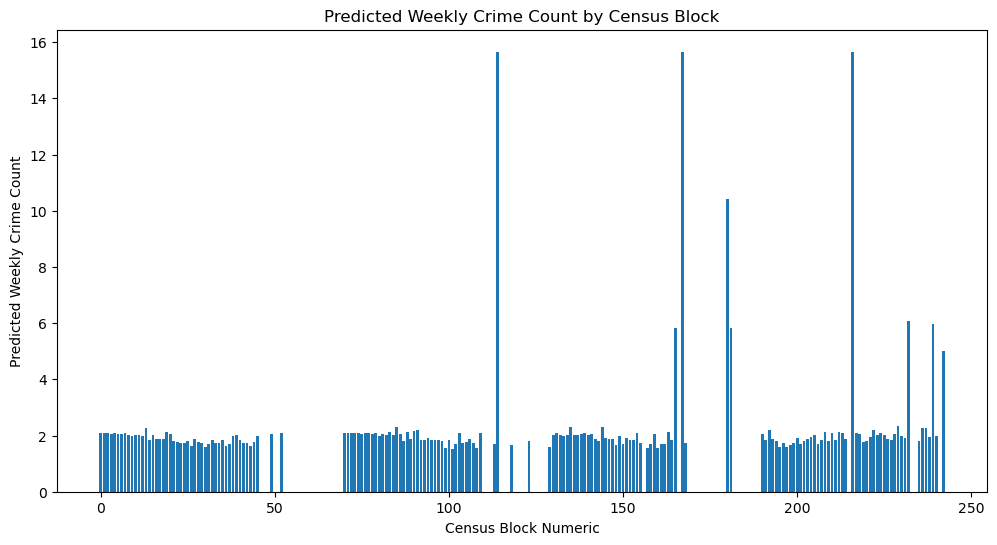

                         Feature  Importance
3        Crime_Count_W_rolling15    0.392737
4         Crime_Count_W_rolling8    0.284830
30          census_block_numeric    0.188087
5         Crime_Count_W_rolling4    0.021100
7         Crime_Count_W_rolling3    0.020288
0                        dow_cos    0.018133
1                        dow_sin    0.015872
17     daylight_lag1_interaction    0.004594
11     temp_rolling3_interaction    0.003882
27    daylight_lag52_interaction    0.003877
8         Crime_Count_W_rolling2    0.003875
2            precipitation_hours    0.003667
25             precipitation_sum    0.003341
21    daylight_lag24_interaction    0.003197
9     temp_rolling15_interaction    0.002393
6                        day_cos    0.002258
10     temp_rolling4_interaction    0.002062
13   precip_rolling2_interaction    0.002050
28                    temp_range    0.002005
12     temp_rolling2_interaction    0.001955
29  precip_rolling15_interaction    0.001954
22        

In [3]:
# crime_prediction.py

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings('ignore')

# Custom Frequency Encoder
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.freq_maps = {}
        
    def fit(self, X, y=None):
        for col in self.categorical_features:
            freq_map = X[col].value_counts(normalize=True).to_dict()
            self.freq_maps[col] = freq_map
        return self
        
    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_features:
            freq_map = self.freq_maps.get(col, {})
            X_encoded[col] = X[col].map(freq_map).fillna(0)
        return X_encoded

def load_data(time_series_path, future_data_path):
    """
    Load the preprocessed time series data and future data.

    Parameters:
    - time_series_path: Path to the preprocessed time series CSV file.
    - future_data_path: Path to the future data CSV file.

    Returns:
    - crime_time_series: DataFrame containing the time series data.
    - future_data: DataFrame containing the future data.
    """
    crime_time_series = pd.read_csv(time_series_path)
    future_data = pd.read_csv(future_data_path)
    return crime_time_series, future_data

def select_features(crime_time_series):
    """
    Select features and target variable for model training.

    Parameters:
    - crime_time_series: DataFrame containing the time series data.

    Returns:
    - X: Feature matrix.
    - y: Target variable.
    - features: List of feature names.
    - categorical_features: List of categorical feature names.
    """
    # Define features
    features = [
        "dow_cos", "dow_sin", "precipitation_hours",
        "Crime_Count_W_rolling15", "Crime_Count_W_rolling8", "Crime_Count_W_rolling4",
        "day_cos", "Crime_Count_W_rolling3", "Crime_Count_W_rolling2",
        "temp_rolling15_interaction", "temp_rolling4_interaction", "temp_rolling3_interaction",
        "temp_rolling2_interaction", "precip_rolling2_interaction", "Crime_Count_W_lag1w",
        "Crime_Count_W_lag4w", "day_sin", "daylight_lag1_interaction", "precip_rolling3_interaction",
        "daylight_lag12_interaction", "daylight_lag4_interaction", "daylight_lag24_interaction",
        "Crime_Count_W_lag52w", "precip_rolling4_interaction", "Crime_Count_W_lag12w",
        "precipitation_sum", "Crime_Count_W_lag24w", "daylight_lag52_interaction",
        "temp_range", "precip_rolling15_interaction"
    ]
    # Define categorical features
    categorical_features = ['census_block_numeric']
    # Prepare feature matrix and target variable
    X = crime_time_series[features + categorical_features]
    y = crime_time_series['Crime_Count_W']
    return X, y, features, categorical_features

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def time_series_cross_validation(model, X, y, k=5):
    """
    Perform time series cross-validation and print metrics.

    Parameters:
    - model: Trained model or pipeline.
    - X: Feature matrix.
    - y: Target variable.
    - k: Number of splits for TimeSeriesSplit.

    Returns:
    - avg_mae: Average Mean Absolute Error across folds.
    - avg_rmse: Average Root Mean Squared Error across folds.
    - avg_r2: Average R² Score across folds.
    - fold_metrics: List of metrics for each fold.
    """
    tscv = TimeSeriesSplit(n_splits=k)
    fold_metrics = []
    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = []
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    # Plot overall residuals (Optional)
    plt.figure(figsize=(12, 6))
    plt.plot(all_y_test, label='Actual')
    plt.plot(all_y_pred, label='Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.xlabel('Time (Ordered Test Samples)')
    plt.ylabel('Values')
    plt.show()

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    return avg_mae, avg_rmse, avg_r2, fold_metrics

def train_model(X, y, features, categorical_features):
    """
    Train the model using RandomizedSearchCV to find best parameters.

    Parameters:
    - X: Feature matrix.
    - y: Target variable.
    - features: List of feature names.
    - categorical_features: List of categorical feature names.

    Returns:
    - best_pipeline: Trained pipeline with best parameters.
    - best_params: Dictionary of best parameters.
    """
    # Define the pipeline
    pipeline = Pipeline([
        ('frequency_encoder', FrequencyEncoder(categorical_features)),
        ('model', XGBRegressor(objective='count:poisson', eval_metric='rmse', random_state=42))
    ])

    # Define parameter distributions for randomized search
    param_distributions = {
        'model__n_estimators': randint(50, 500),
        'model__max_depth': randint(3, 10),
        'model__learning_rate': uniform(0.01, 0.19),
        'model__subsample': uniform(0.6, 0.4),
        'model__colsample_bytree': uniform(0.6, 0.4),
        'model__gamma': uniform(0, 1),
        'model__reg_alpha': uniform(0, 1),
        'model__reg_lambda': uniform(0, 1.5)
    }

    # Set up TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Define the scorer
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Implement RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=100,
        scoring=scorer,
        cv=tscv,
        verbose=2,
        n_jobs=-1,
        random_state=42,
        return_train_score=False
    )

    # Fit RandomizedSearchCV
    random_search.fit(X, y)

    # Extract best parameters and score
    print(f"Best MAE Score: {-random_search.best_score_:.4f}")
    print("Best Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")

    # Extract best pipeline
    best_pipeline = random_search.best_estimator_

    best_params = {key.replace('model__', ''): value for key, value in random_search.best_params_.items()}

    # Save the best pipeline (model and frequency encoding)
    joblib.dump(best_pipeline, 'crime_prediction_model.pkl')

    return best_pipeline, best_params

def make_future_predictions(best_pipeline, future_data, features, categorical_features):
    """
    Use the trained model to predict future crime counts.

    Parameters:
    - best_pipeline: Trained pipeline with best parameters.
    - future_data: DataFrame containing the future data.
    - features: List of feature names.
    - categorical_features: List of categorical feature names.

    Returns:
    - future_data: DataFrame with predictions added.
    """
    # Select the same features as in training
    X_future = future_data[features + categorical_features]

    # Predict future crime counts
    y_future_pred = best_pipeline.predict(X_future)

    # Reverse log transformation if applied (assuming log1p was used)
    y_future_pred = np.expm1(y_future_pred)

    # Add predictions to your future data
    future_data['Predicted_Crime_Count_W'] = y_future_pred

    # Save predictions to CSV
    future_data[['census_block_numeric', 'date', 'Predicted_Crime_Count_W']].to_csv('future_data_preds.csv', index=False)

    return future_data

def plot_future_predictions(future_data):
    """
    Plot predicted weekly crime counts by census block.

    Parameters:
    - future_data: DataFrame containing future data with predictions.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(future_data['census_block_numeric'], future_data['Predicted_Crime_Count_W'])
    plt.xlabel('Census Block Numeric')
    plt.ylabel('Predicted Weekly Crime Count')
    plt.title('Predicted Weekly Crime Count by Census Block')
    plt.show()

def display_feature_importances(best_pipeline, X):
    """
    Display feature importances from the trained model.

    Parameters:
    - best_pipeline: Trained pipeline with best parameters.
    - X: Feature matrix used in training.
    """
    # Get feature importances from the model
    feature_importances = best_pipeline.named_steps['model'].feature_importances_

    # Create a DataFrame to display them
    importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(importances_df)

def main():
    # Step 1: Load Data
    crime_time_series, future_data = load_data("crime_time_series_2.csv", "future_data.csv")
    print("Data Loaded.")
    print(f"Time Series Data Shape: {crime_time_series.shape}")
    print(f"Future Data Shape: {future_data.shape}")

    # Step 2: Select Features
    X, y, features, categorical_features = select_features(crime_time_series)
    print("Features Selected.")

    # Step 3: Train Model
    best_pipeline, best_params = train_model(X, y, features, categorical_features)
    print("Model Trained.")

    # Step 4: Cross-Validation
    avg_mae, avg_rmse, avg_r2, metrics = time_series_cross_validation(best_pipeline, X, y)
    print("Cross-Validation Completed.")

    # Step 5: Predict Future Data
    future_data_with_predictions = make_future_predictions(best_pipeline, future_data, features, categorical_features)
    print("Future Predictions Made.")

    # Save future data with predictions
    future_data_with_predictions.to_csv("future_data_with_predictions.csv", index=False)

    # Optional: Plot Predictions
    plot_future_predictions(future_data_with_predictions)

    # Optional: Display Feature Importances
    display_feature_importances(best_pipeline, X)

if __name__ == "__main__":
    main()